In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset, collate_fn_pre_train
from model.autoencoder_ts import TimeSeriesAutoencoder, TransformerAutoencoder
from pre_train_autoencoder import train_model, test_model, visualize_reconstruction, generate_mask,masked_mae_loss,calculate_correlation


In [2]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [3]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn_pre_train)
lstm_loader_val = DataLoader(lstm_dataset_val, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)
lstm_loader_test = DataLoader(lstm_dataset_test, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)

In [4]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"]).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(lstm_model.parameters(), lr=best_config["lr"])

In [ ]:
train_model(lstm_model, lstm_loader_train, lstm_loader_val, criterion, optimizer, best_config, device)

In [ ]:
best_model_path = "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder/best_model_32_1e-4.pth"
lstm_model.load_state_dict(torch.load(best_model_path,weights_only=True))
lstm_model.eval()
test_model(lstm_model, lstm_loader_test, criterion, device)

In [ ]:
visualize_reconstruction(lstm_model, lstm_loader_test, device,feature_indices=[1])

## overfit model

In [4]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"]).to(device)

optimizer = optim.Adam(lstm_model.parameters(), lr=best_config["lr"])

In [5]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [7]:
## 0 as decoder input
num_epochs = 500  
for epoch in range(num_epochs):
    lstm_model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs, _ = lstm_model(inputs, lengths,decoder_h=False)
        
        mask = generate_mask(inputs.size(1), lengths, device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer.step()

        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f},Correlation: {corr:.6f}")


Epoch 50, Loss: 0.247190,Correlation: 0.120419
Epoch 100, Loss: 0.214226,Correlation: 0.303929
Epoch 150, Loss: 0.153654,Correlation: 0.538562
Epoch 200, Loss: 0.104685,Correlation: 0.693101
Epoch 250, Loss: 0.074356,Correlation: 0.784777
Epoch 300, Loss: 0.053935,Correlation: 0.835151
Epoch 350, Loss: 0.042899,Correlation: 0.856428
Epoch 400, Loss: 0.038806,Correlation: 0.865483
Epoch 450, Loss: 0.037002,Correlation: 0.869259
Epoch 500, Loss: 0.036635,Correlation: 0.871024


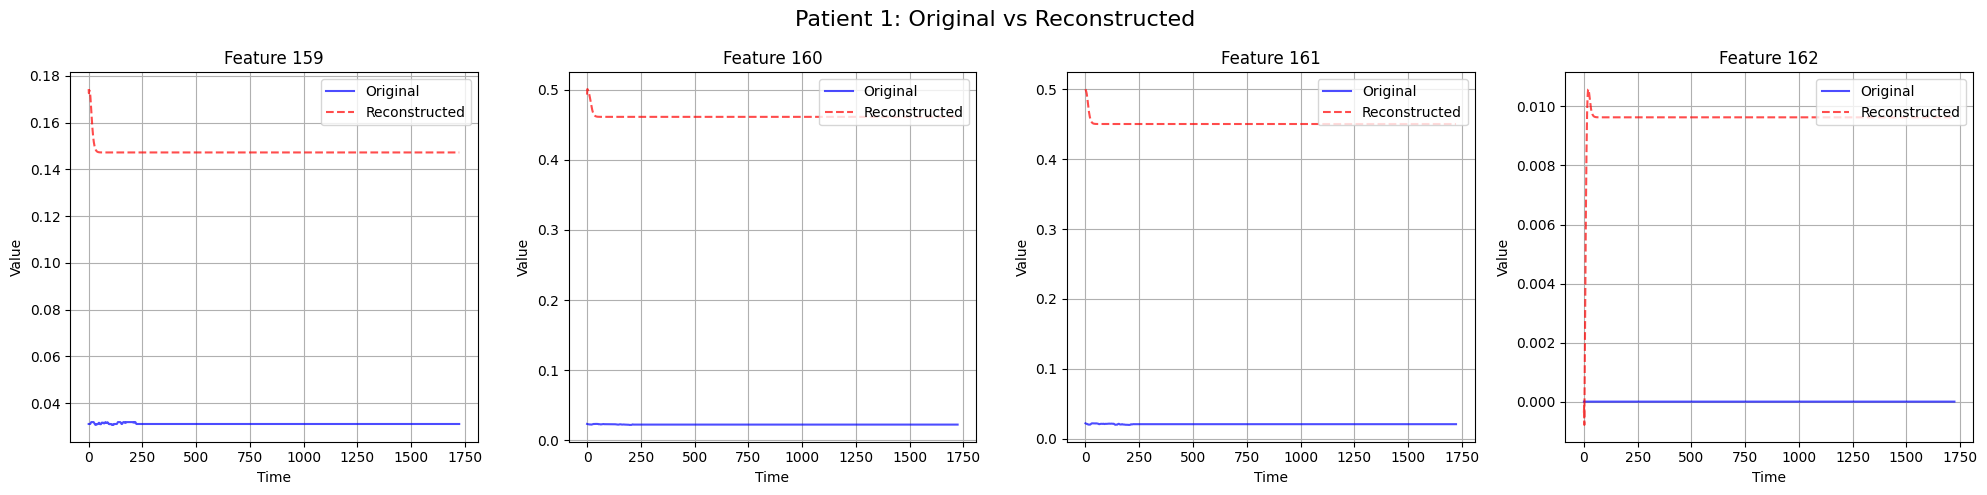

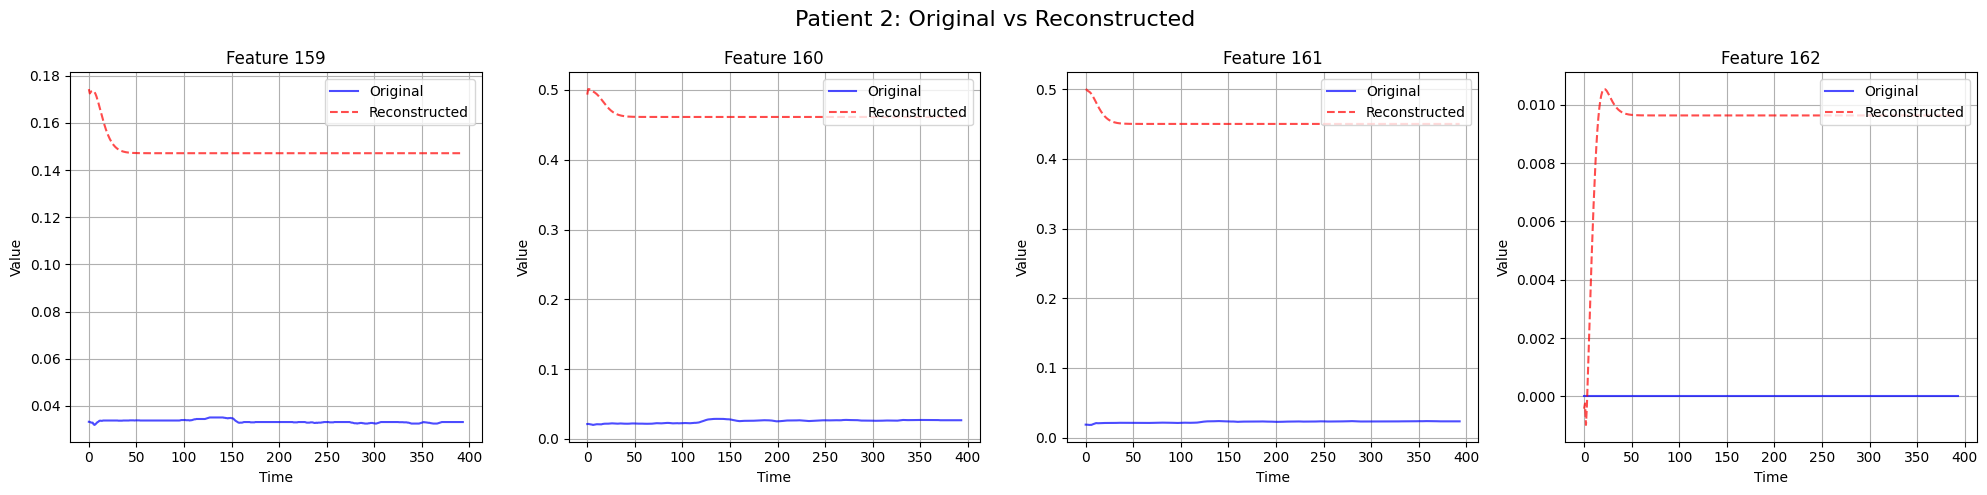

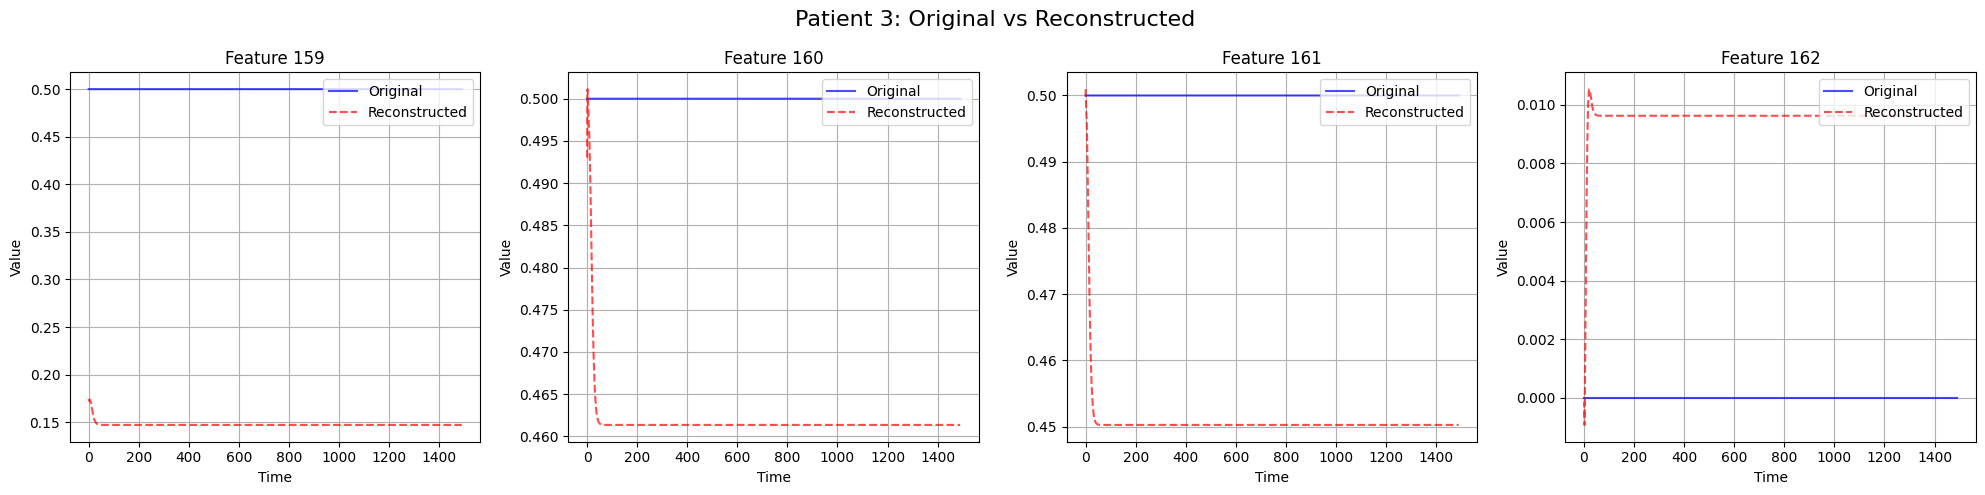

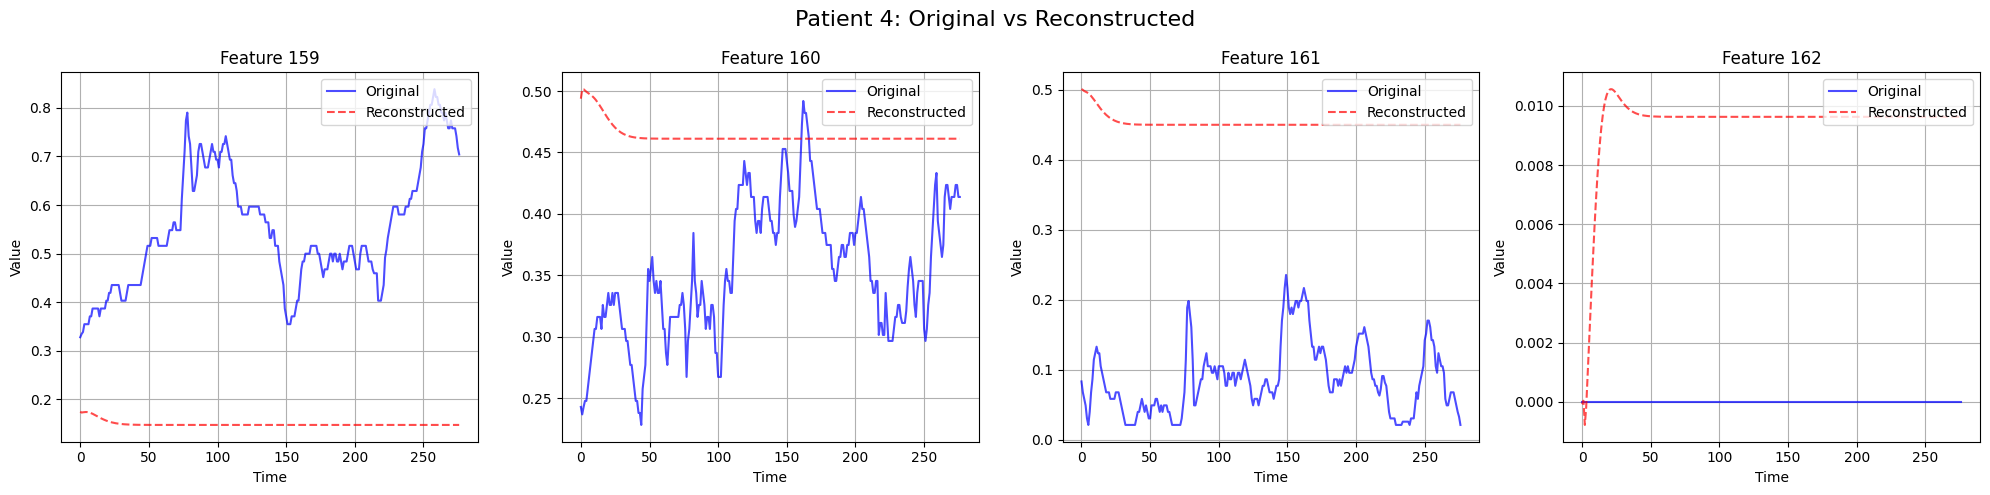

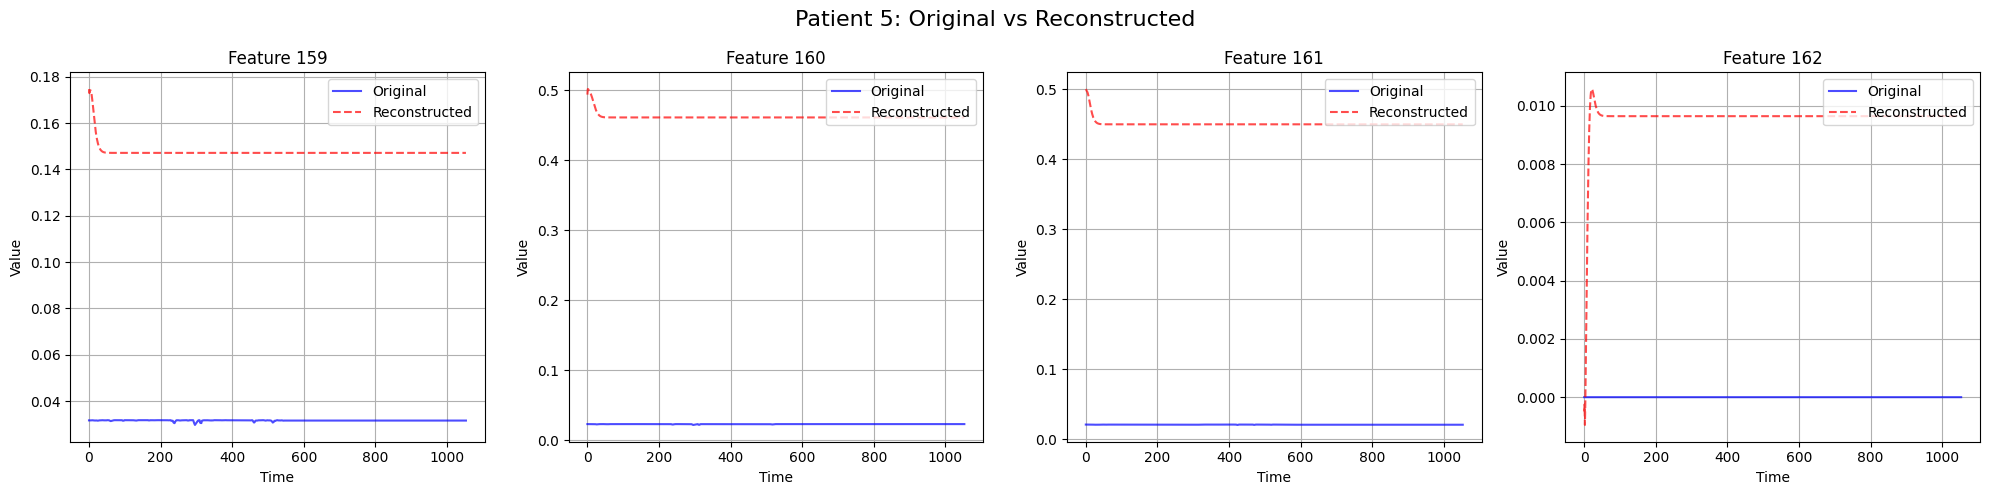

In [8]:
visualize_reconstruction(lstm_model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162])

In [6]:
# hidden state as decoder input
num_epochs = 500  
for epoch in range(num_epochs):
    lstm_model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs, _ = lstm_model(inputs, lengths,decoder_h=True)
        
        mask = generate_mask(inputs.size(1), lengths, device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer.step()
        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f},Correlation: {corr:.6f}")


Epoch 50, Loss: 0.260069,Correlation: 0.112296
Epoch 100, Loss: 0.235029,Correlation: 0.253923
Epoch 150, Loss: 0.182736,Correlation: 0.496471
Epoch 200, Loss: 0.113954,Correlation: 0.686140
Epoch 250, Loss: 0.073703,Correlation: 0.784871
Epoch 300, Loss: 0.052559,Correlation: 0.837535
Epoch 350, Loss: 0.042785,Correlation: 0.862554
Epoch 400, Loss: 0.037778,Correlation: 0.871077
Epoch 450, Loss: 0.035810,Correlation: 0.874459
Epoch 500, Loss: 0.034787,Correlation: 0.876194


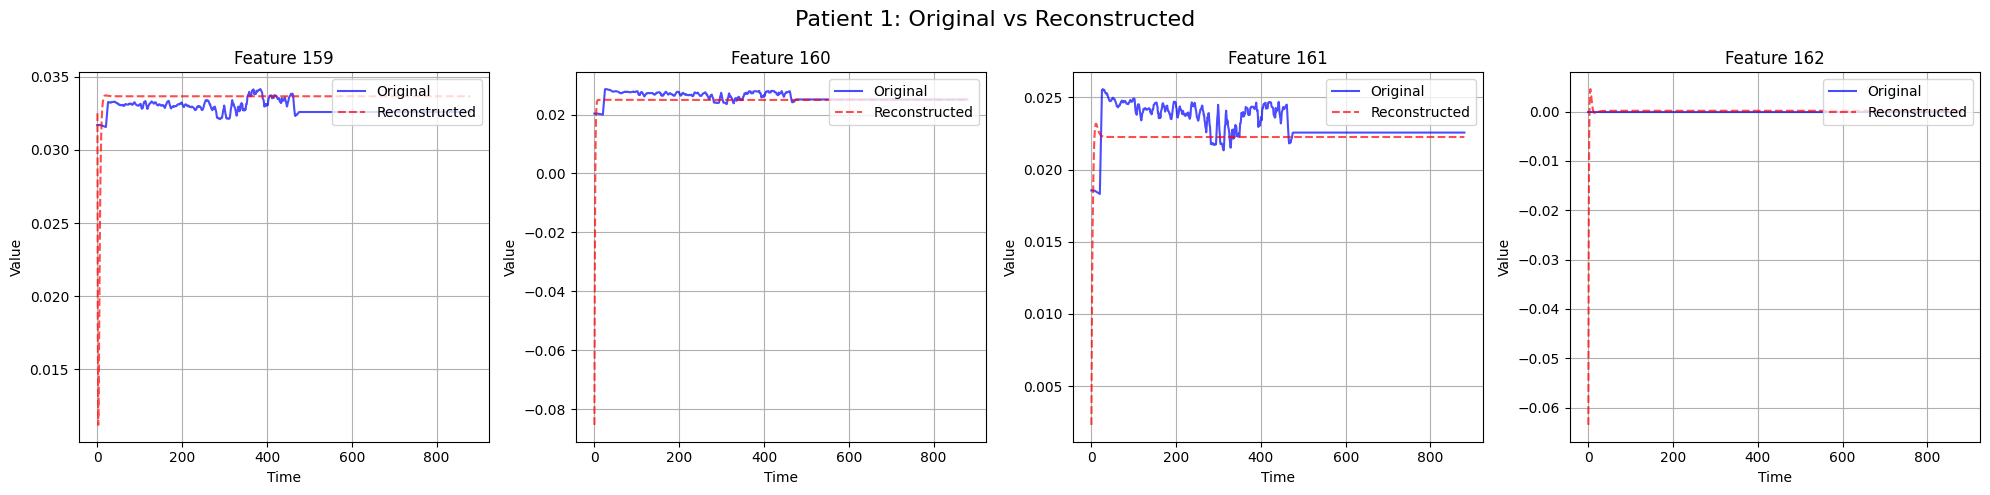

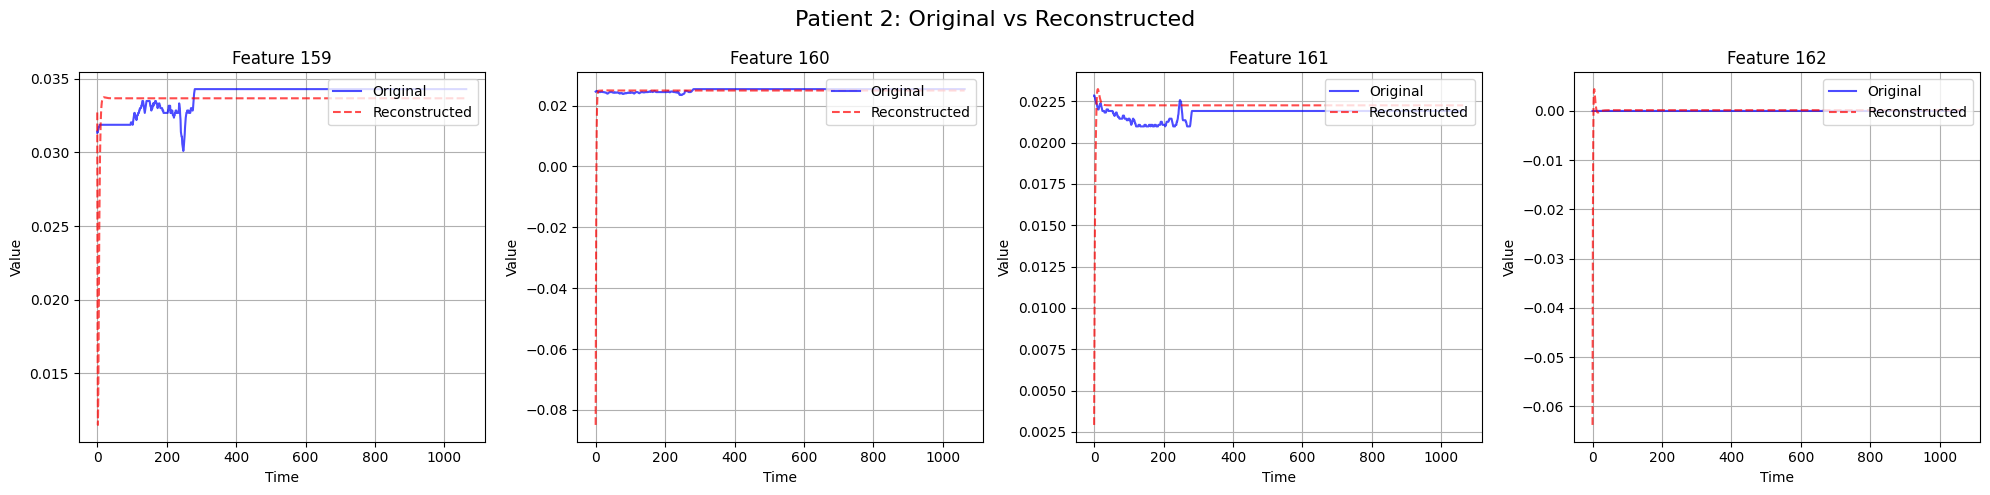

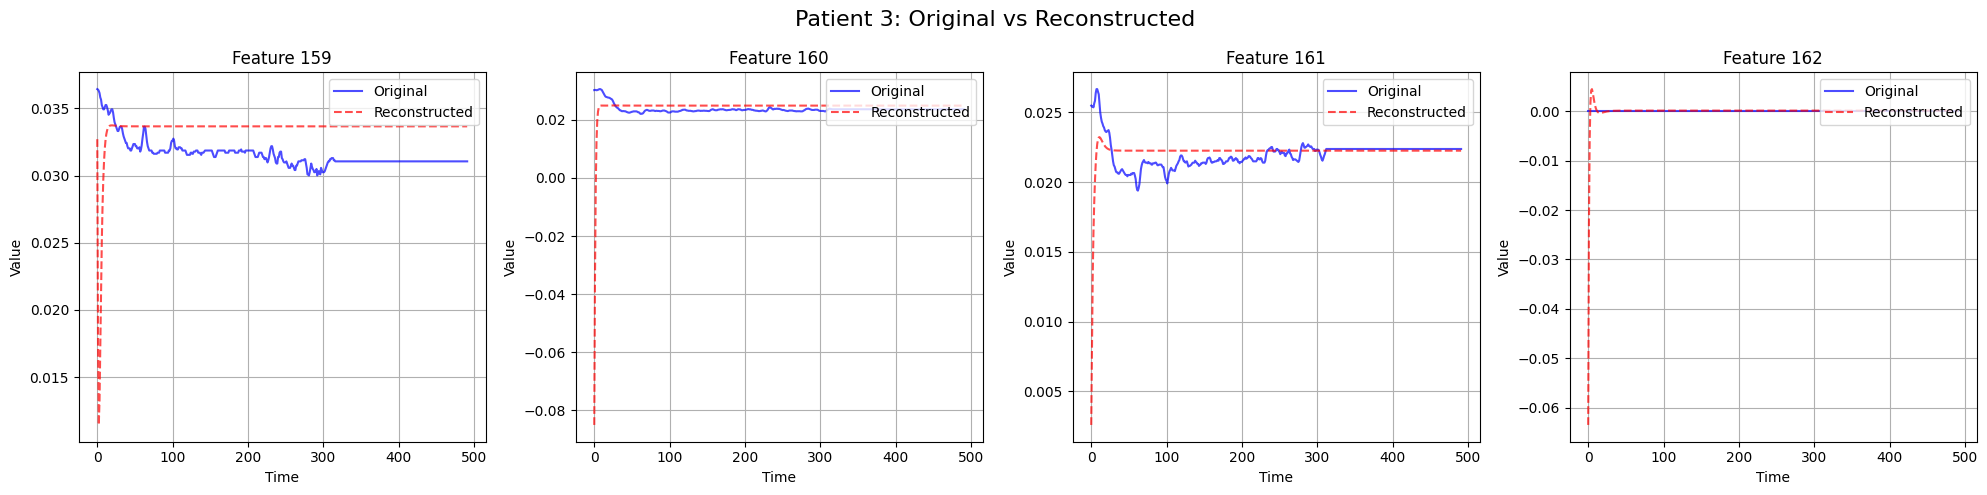

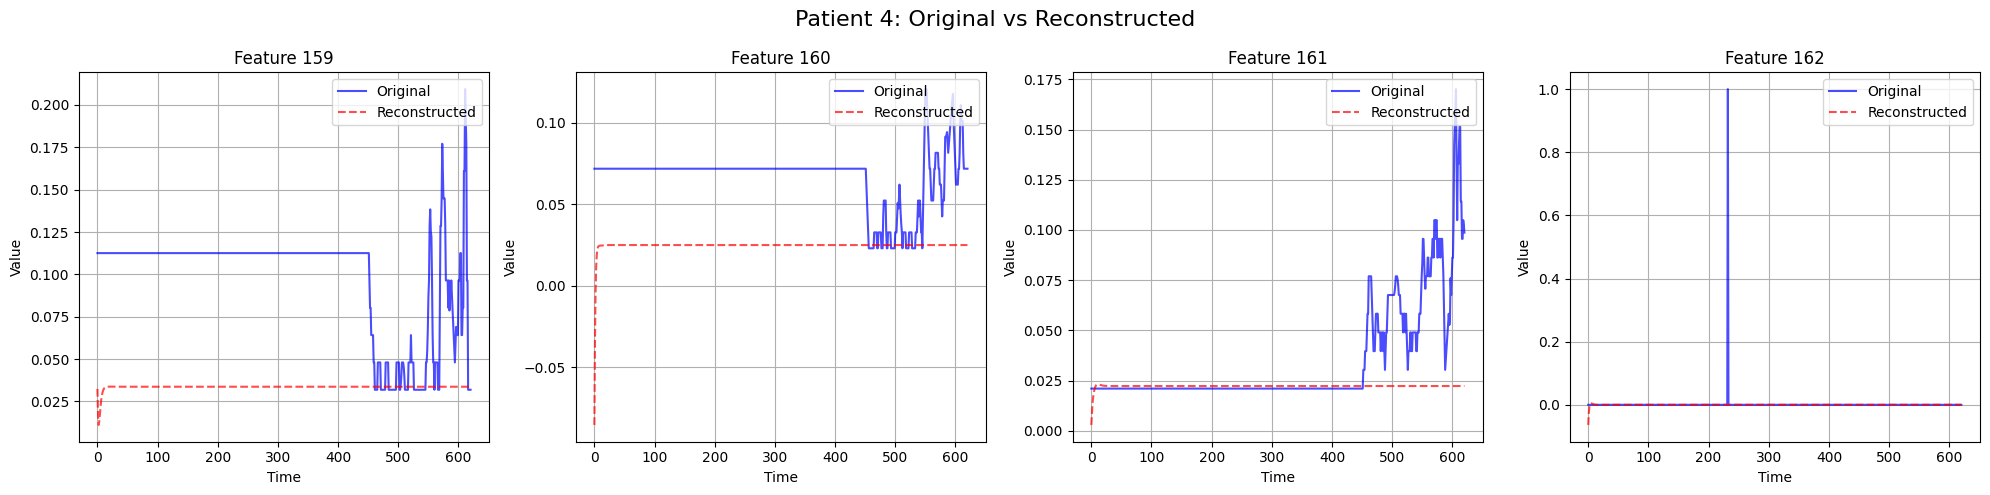

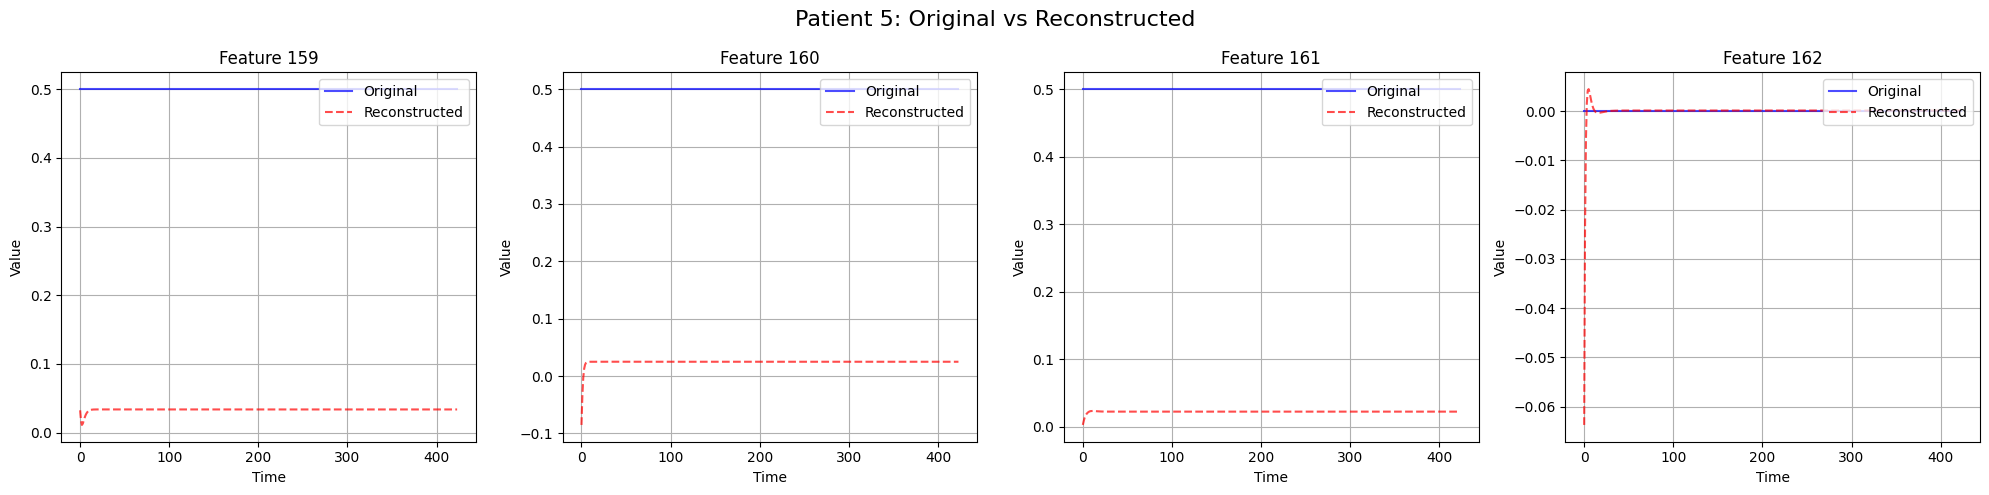

In [7]:
visualize_reconstruction(lstm_model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162])

## transformer autoencoder

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trans_model = TransformerAutoencoder(input_dim=324, hidden_dim=32, num_heads=4, num_layers=2).to(device)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=0.0001)


In [9]:
num_epochs = 500  
for epoch in range(num_epochs):
    trans_model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = trans_model(inputs)

        mask = generate_mask(inputs.size(1), lengths,device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)
        torch.nn.utils.clip_grad_norm_(trans_model.parameters(), max_norm=1.0)
        
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f},Correlation: {corr:.6f}")


Epoch 50, Loss: 0.119109,Correlation: 0.802297
Epoch 100, Loss: 0.103010,Correlation: 0.833138
Epoch 150, Loss: 0.095585,Correlation: 0.845241
Epoch 200, Loss: 0.090499,Correlation: 0.853539
Epoch 250, Loss: 0.085940,Correlation: 0.861934
Epoch 300, Loss: 0.080896,Correlation: 0.872078
Epoch 350, Loss: 0.074670,Correlation: 0.881902
Epoch 400, Loss: 0.065563,Correlation: 0.893049
Epoch 450, Loss: 0.054523,Correlation: 0.904158
Epoch 500, Loss: 0.047252,Correlation: 0.910228


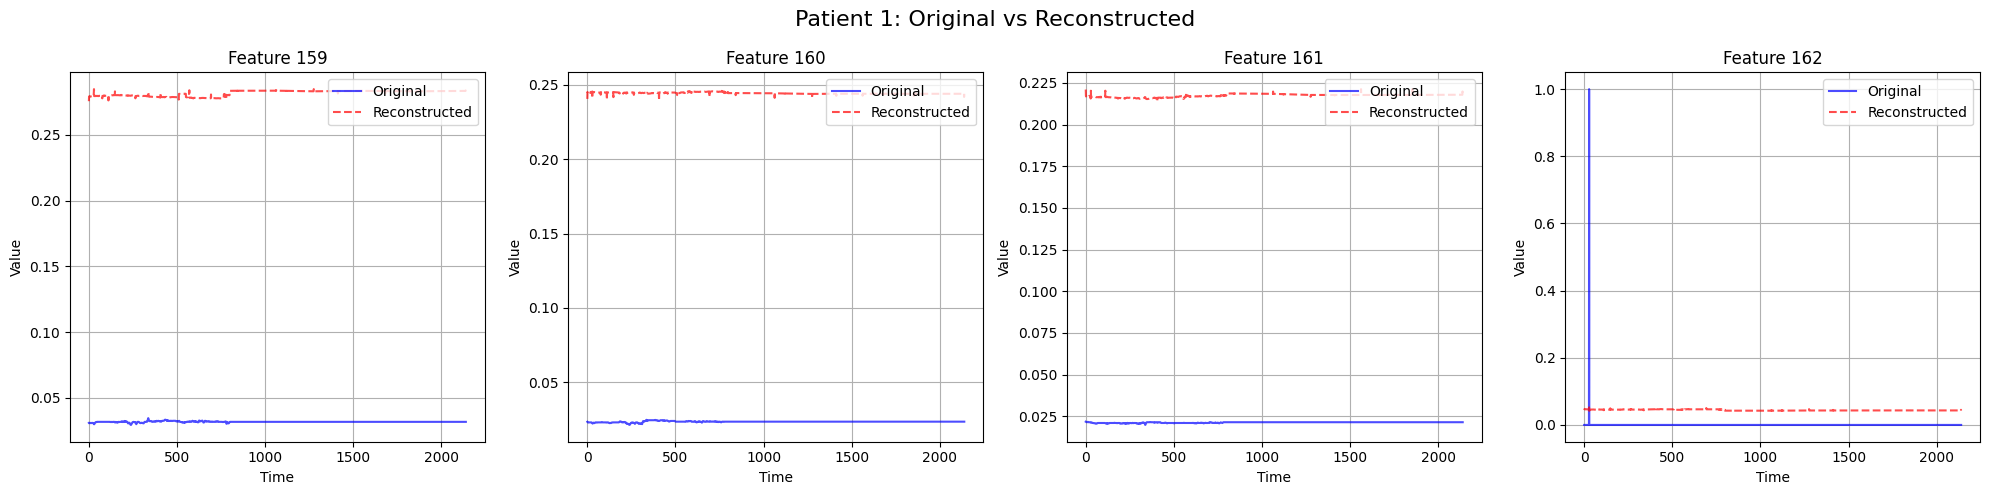

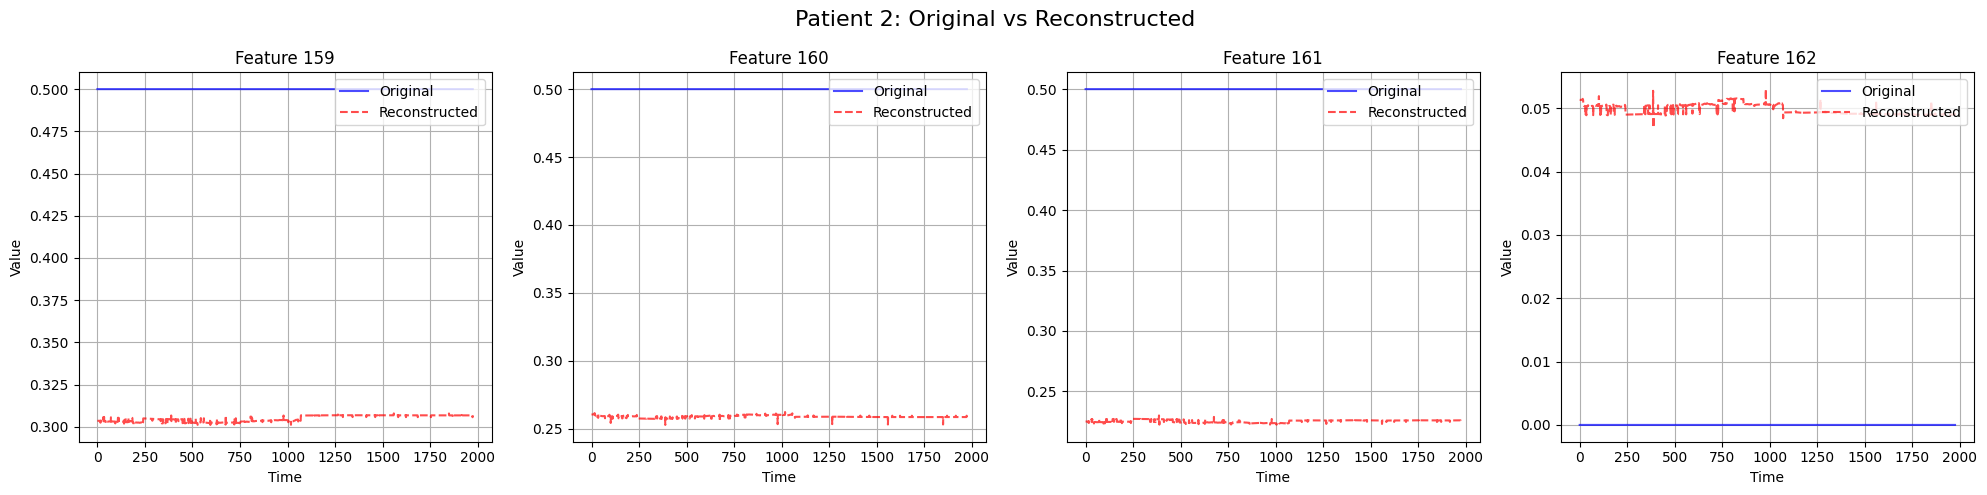

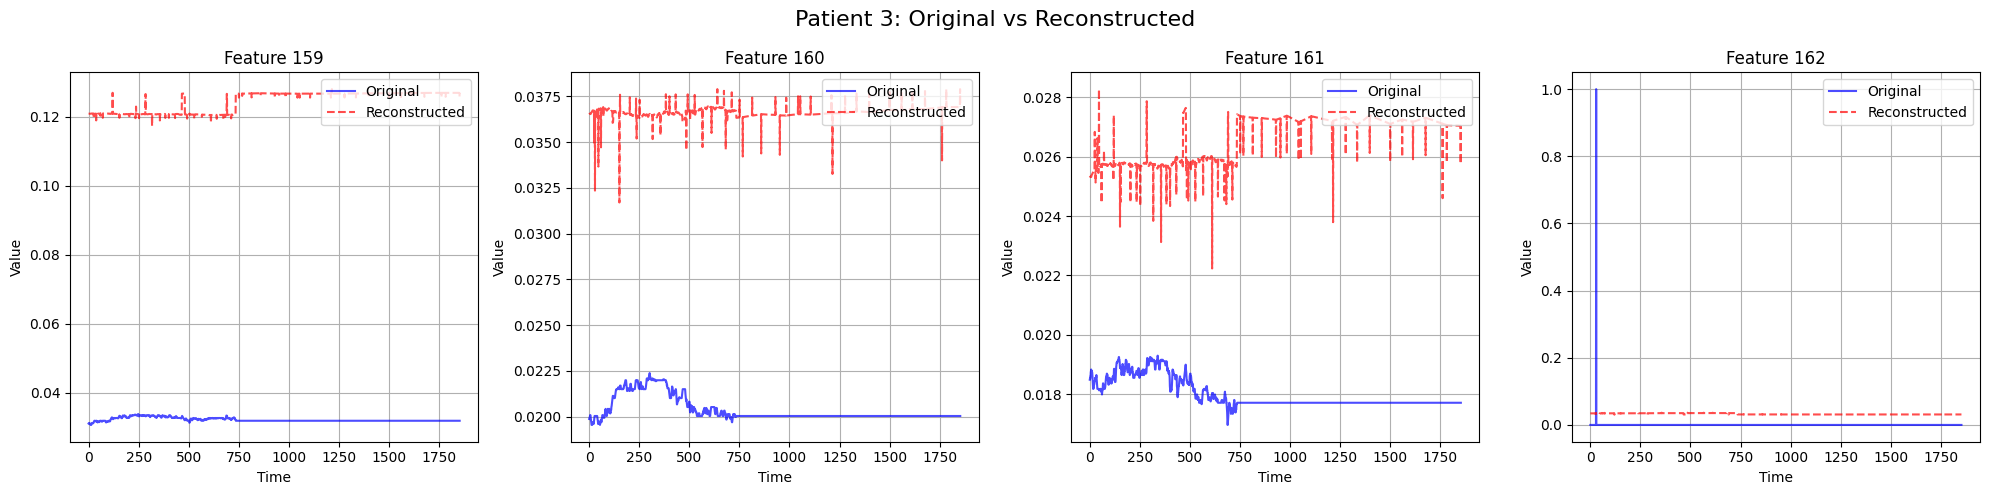

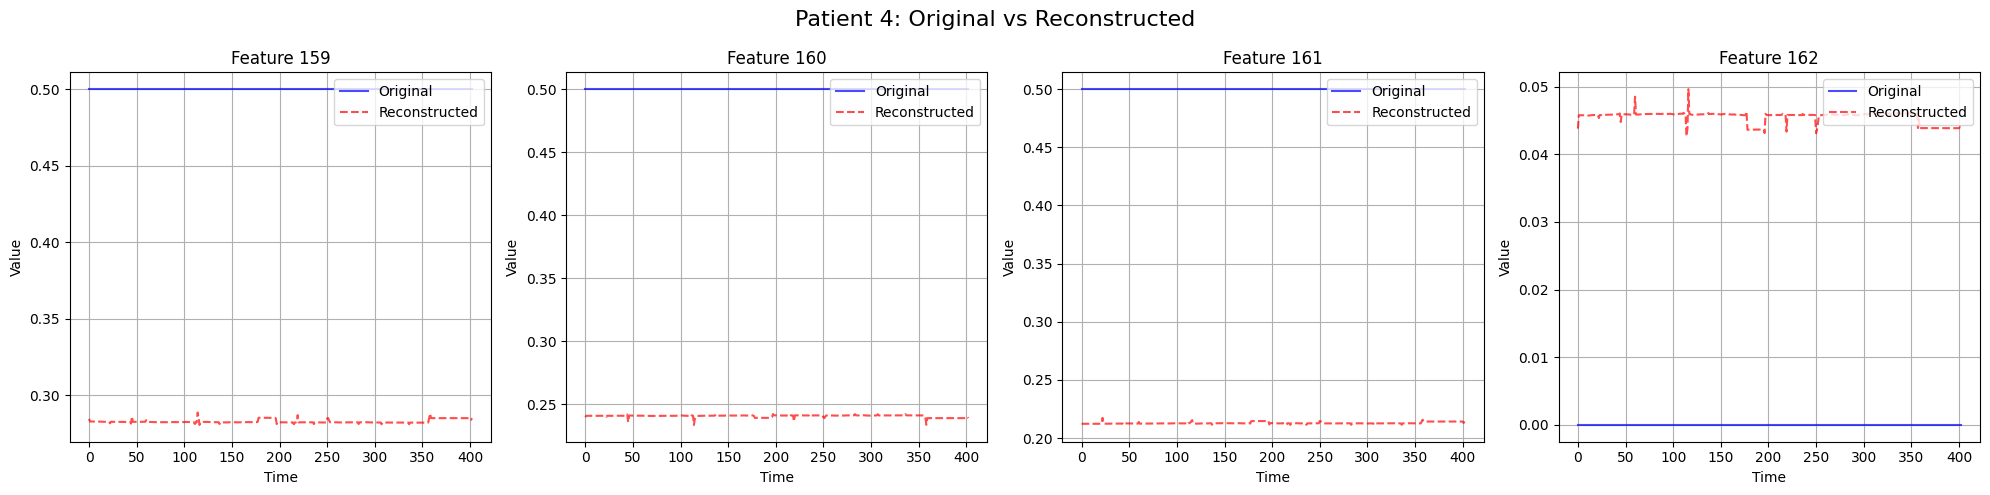

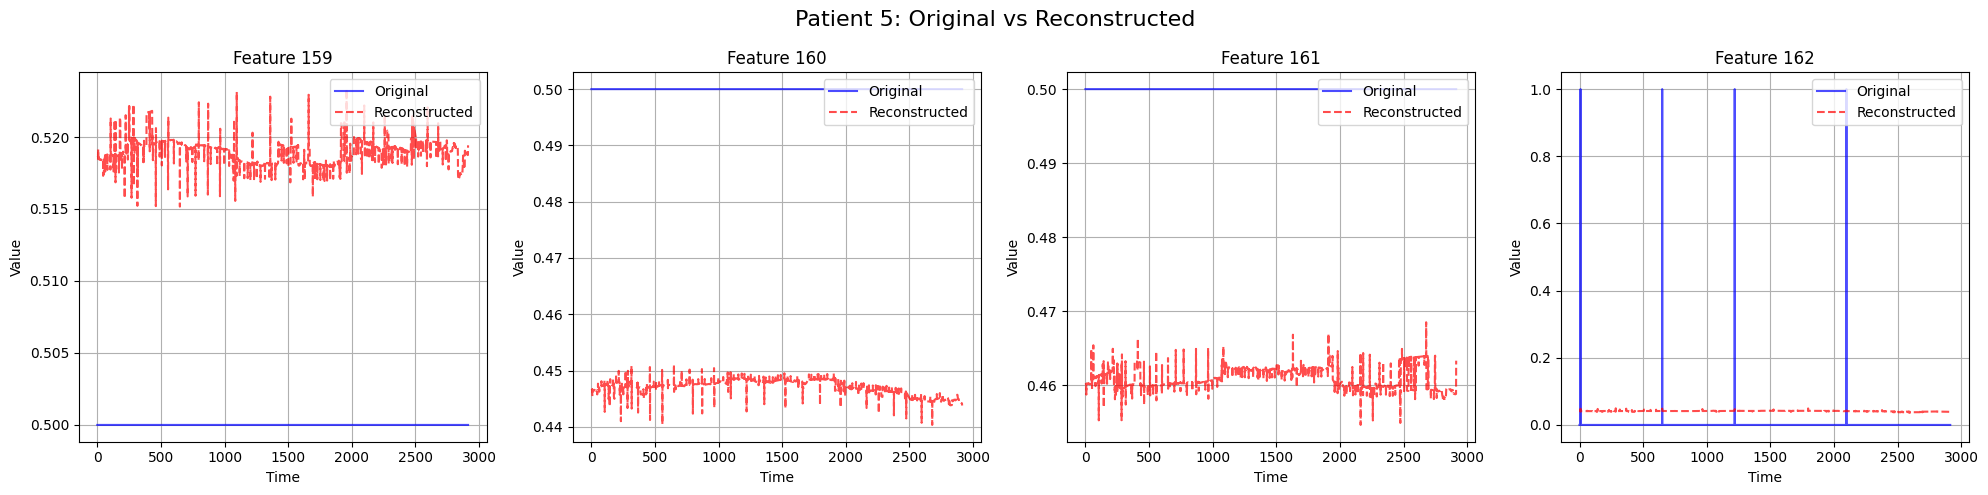

In [10]:
visualize_reconstruction(trans_model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162],transformer=True)